Daniel Diamont (dd28977)
John Sigmon (jsjs85773)

In [5]:
import pandas as pd
import numpy as np
import sklearn as sk

# algorithms and helpers
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew
from scipy.stats import pearsonr
from pandas.plotting import scatter_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/home/daniel/Documents/Fall_2018/Data_Mining/data_science_principles/.env/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d



# <p style="text-align: center;">EE 461P: Data Science Principles</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 75</p>
## <p style="text-align: center;">Due: Thursday, October 25th, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  **Please include the name and UTEID for both students on all submitted files (including this notebook).** In addition, please convert **your filename including your EID** (ex. ss324.jpynb or ss324_mj345.jpypb).

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1a - Stochastic Gradient Descent (25pts)

1. (4pts) Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, include the image in your notebook.

ANSWER

2. (12pts) Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2$$ Try to format similarly to scikit-learn's models. Your class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'sgd' or 'sgd_momentum' or 'rmsprop'(Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 15 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate and regularization for SGD, SGD-Momentum and RMSProp. I.e., you should have one plot of MSE and another for the parameter updates for SGD, SGD-Momentum and RMSProp (6 plots total).

In [132]:
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

class SGD(BaseEstimator):
    
    def __init__(self, learning_rate=0.0001, Lambda=0, epochs=100):
        self.learning_rate = learning_rate
        self.Lambda = Lambda
        self.epochs = epochs
    
    def fit(self, data, label, update_rule='sgd'):
        """
        fit takes in data, label, and an update rule.
        Args:
            data   (np.ndarray): Must be randomly loaded from data set to be SGD
            label  (np.ndarray): Target labels
            update_rule (string): 
        """
#         print("Data: {}".format(data.shape))
#         print("label: {}".format(label.shape))

        # center data
        data = (data-data.mean())/data.std()
        label = (label-label.mean())/label.std()
        
        W = np.random.uniform(size=(data.shape[1],))
        
#         print("Weights: {}".format(W.shape))
        
        W = W.reshape(1,-1)
        
#         print("Reshaped Weights: {}".format(W.shape))
        
        velocity = (np.zeros((data.shape[1],))).reshape(1,-1)
#         print("V: " + str(velocity.shape))
        
        self.update_rule = update_rule
        self.data = data
        self.label = label
        
        mse_hist = []
        W0_hist = []
        W1_hist = []
        
        for epoch in np.arange(0, self.epochs):
            
            mse = []
            W_epoch0 = np.zeros(data.shape[0],)
            W_epoch1 = np.zeros(data.shape[0],)
            i = 0
            
#             print("EPOCH: " + str(epoch))
            
            for (batchX, batchY) in self.next_batch(data, label):
                
#                 print("batchX: {}".format(batchX.shape))
#                 print("batchY: {}".format(batchY.shape))
                
                pred = self.sigmoid((np.dot(batchX, W.T)))

                error = mean_squared_error(pred,batchY)
#                 print("error: {}".format(error.shape))
                loss = (error) + self.Lambda*(np.dot(W, W.T))
                mse.append(error)
                
                gradient = (2 * batchX * np.asscalar(np.array(error))) + (2 * self.Lambda * W)
            
#                 print("*************")
#                 print("W: " + str(W))
#                 print()
#                 print("error: " + str(error))
#                 print()
#                 print("loss: " + str(loss))
#                 print()
#                 print("gradient: " + str(gradient))
#                 print("**************")
                
                if(update_rule is 'sgd'):
                    W += -self.learning_rate * gradient
                    W_epoch0[i] = W[0][0]
                    W_epoch1[i] = W[0][1]
                    i = i + 1

                elif(update_rule is 'sgd_momentum'):
                    gradient = np.array(gradient)
                    velocity =  (0.9 * velocity) - (self.learning_rate * gradient)
                    W += velocity
                    W_epoch0[i] = W[0][0]
                    W_epoch1[i] = W[0][1]
                    i = i + 1
                    
                elif(update_rule is 'rmsprop'):
                    gradient = np.array(gradient)
                    velocity = (0.9 * velocity) + (0.1 * np.dot(gradient, gradient.T))
                    delta_W = (self.learning_rate * gradient)/(np.sqrt(velocity + 1e-6))
                    W = W - delta_W
                    W_epoch0[i] = W[0][0]
                    W_epoch1[i] = W[0][1]
                    i = i + 1

                else:
                    raise velocityalueError('invalid update rule')
            
            mse_hist.append(np.array(mse).mean())
            W0_hist.append(W_epoch0.mean())
            W1_hist.append(W_epoch1.mean())

        self.W = W
        self.mse_hist = mse_hist
        self.W0_hist = W0_hist
        self.W1_hist = W1_hist
        return self
        
    def get_params(self, deep=True):
        param_dict = {'learning_rate': self.learning_rate,
                     'Lambda': self.Lambda,
                     'epochs': self.epochs,}
        
        return param_dict
    
    def set_params(self, **param_dict):
        self.learning_rate = param_dict['learning_rate']
        self.Lambda = param_dict['Lambda']
        self.epochs = param_dict['epochs']
        
        return self
    
    def predict(self, X):
        return np.dot(X, self.W.T)
    
    def next_batch(self, X, y):
        for i in np.arange(0, X.shape[0], 1):
            yield (X[i:i + 1], y[i:i + 1])
            
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

In [133]:
sgd = SGD()

Use your new gradient descent regression to predict the data given in 'samples.csv', for 15 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the w parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate and regularization for SGD, SGD-Momentum and RMSProp. I.e., you should have one plot of MSE and another for the parameter updates for SGD, SGD-Momentum and RMSProp (6 plots total).

In [134]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

samples = pd.read_csv('samples.csv')

samples.head()

,Unnamed: 0,x1,x2,y
0,0,4.697532,1.135251,-18.284819
1,1,-0.324355,1.042443,-0.251914
2,2,-0.982079,4.053857,-2.350819
3,3,2.637966,4.107375,-2.831104
4,4,4.359560,3.727414,-12.663515


In [135]:
samples_X = samples[['x1', 'x2']]
samples_y = samples[['y']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples_X,
                                                    samples_y,
                                                    test_size = 0.2,
                                                    random_state=42)


In [136]:
X_train.shape

(40, 2)

In [137]:
y_train.shape

(40, 1)

In [138]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
r = SGDRegressor()
r.fit(X_train,y_train)
r.coef_

array([-0.89383182, -0.76824572])

In [139]:
y_pred = r.predict(X_train)
mean_squared_error(y_pred, y_train)

46.603672328973246

In [140]:
sgd.fit(X_train, y_train)
sgd.W

array([[-0.08537268,  0.6014931 ]])

In [141]:
y_p = sgd.predict(X_train)
mean_squared_error(y_p, y_train)

90.24387987397617

### Grid Search using SGD

In [142]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# output diverges for learning_rate' >= 0.1

parameters = {'learning_rate': [.0001, .001, .01],
              'Lambda':[0, 10, 100],
               'epochs': [15]}

grid = GridSearchCV(sgd, parameters, 
                   cv=5, 
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   refit=True,
                   error_score='raise',)

_ = grid.fit(X_train, y_train, update_rule='sgd')

In [143]:
results = pd.DataFrame(grid.cv_results_)
results = results[['mean_test_score', 'param_learning_rate', 'param_Lambda']]
results = results.sort_values('mean_test_score', ascending=False)
results.iloc[0:2,:]

,mean_test_score,param_learning_rate,param_Lambda
6,-76.607049,0.0001,100
7,-76.934116,0.001,100


In [144]:
best0 = SGD(learning_rate=0.0001, Lambda=100, epochs=15)
best0.fit(X_train, y_train)

best1 = SGD(learning_rate=0.001, Lambda=100, epochs=15)
best1.fit(X_train, y_train)

SGD(Lambda=100, epochs=15, learning_rate=0.001)

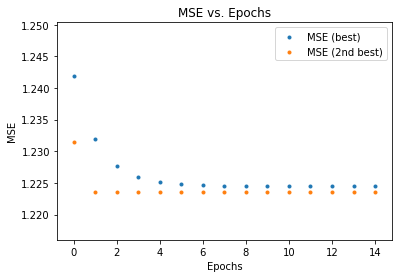

In [145]:
_ = plt.scatter(range(15), best0.mse_hist, label='MSE (best)', marker='.')
_ = plt.scatter(range(15), best1.mse_hist, label='MSE (2nd best)', marker='.')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("MSE")
_ = plt.title("MSE vs. Epochs")
_ = plt.legend()
plt.show()

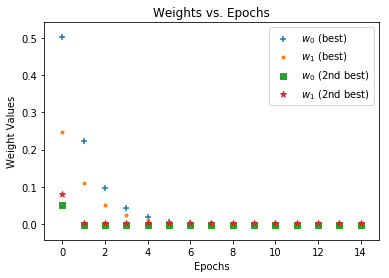

In [101]:
plt.scatter(range(15), best0.W0_hist, label='$ w_0 $ (best)', marker="+")
plt.scatter(range(15), best0.W1_hist, label='$ w_1 $ (best)', marker='.')
plt.scatter(range(15), best1.W0_hist, label='$ w_0 $ (2nd best)', marker=",")
plt.scatter(range(15), best1.W1_hist, label='$ w_1 $ (2nd best)', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Weight Values")
plt.title("Weights vs. Epochs")
plt.legend()
plt.show()

### Grid Search using SGD w/ Momentum

In [146]:
parameters = {'learning_rate': [.0001, .001, .01,],
              'Lambda':[0, 10, 100],
               'epochs': [15]}

grid_momentum = GridSearchCV(sgd, parameters, 
                   cv=5, 
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   refit=True,
                   error_score='raise',)

_ = grid_momentum.fit(X_train, y_train, update_rule='sgd_momentum')

In [147]:
results = pd.DataFrame(grid_momentum.cv_results_)
results = results[['mean_test_score', 'param_learning_rate', 'param_Lambda']]
results = results.sort_values('mean_test_score', ascending=False)
results.iloc[0:2,:]

,mean_test_score,param_learning_rate,param_Lambda
6,-76.569620,0.0001,100
7,-76.779181,0.001,100


In [148]:
best0_mom = SGD(learning_rate=0.0001, Lambda=100, epochs=15)
best0_mom.fit(X_train, y_train, update_rule='sgd_momentum')

best1_mom = SGD(learning_rate=0.001, Lambda=100, epochs=15)
best1_mom.fit(X_train, y_train, update_rule='sgd_momentum')

SGD(Lambda=100, epochs=15, learning_rate=0.001)

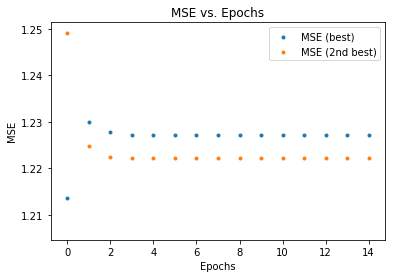

In [151]:
_ = plt.scatter(range(15), best0_mom.mse_hist, label='MSE (best)', marker='.')
_ = plt.scatter(range(15), best1_mom.mse_hist, label='MSE (2nd best)', marker='.')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("MSE")
_ = plt.title("MSE vs. Epochs")
_ = plt.legend()
plt.show()

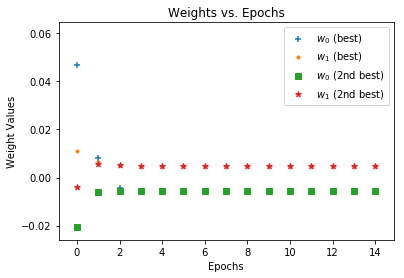

In [152]:
plt.scatter(range(15), best0_mom.W0_hist, label='$ w_0 $ (best)', marker="+")
plt.scatter(range(15), best0_mom.W1_hist, label='$ w_1 $ (best)', marker='.')
plt.scatter(range(15), best1_mom.W0_hist, label='$ w_0 $ (2nd best)', marker=",")
plt.scatter(range(15), best1_mom.W1_hist, label='$ w_1 $ (2nd best)', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Weight Values")
plt.title("Weights vs. Epochs")
plt.legend()
plt.show()

### Grid Search using RMSprop

In [153]:
parameters = {'learning_rate': [.0001, .001, .01, 0.1, 1, 100],
              'Lambda':[0, 10, 100],
               'epochs': [15]}

grid_rmsprop = GridSearchCV(sgd, parameters, 
                   cv=5, 
                   scoring='neg_mean_squared_error',
                   verbose=0,
                   refit=True,
                   error_score='raise',)

_ = grid_rmsprop.fit(X_train, y_train, update_rule='rmsprop')

In [154]:
results = pd.DataFrame(grid_rmsprop.cv_results_)
results = results[['mean_test_score', 'param_learning_rate', 'param_Lambda']]
results = results.sort_values('mean_test_score', ascending=False)
results.iloc[0:2,:]

,mean_test_score,param_learning_rate,param_Lambda
14,-76.870774,0.01,100
8,-77.366719,0.01,10


In [155]:
best0_rms = SGD(learning_rate=1, Lambda=100, epochs=15)
best0_rms.fit(X_train, y_train, update_rule='rmsprop')

best1_rms = SGD(learning_rate=0.01, Lambda=100, epochs=15)
best1_rms.fit(X_train, y_train, update_rule='rmsprop')

SGD(Lambda=100, epochs=15, learning_rate=0.01)

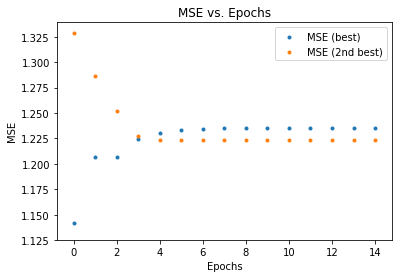

In [156]:
_ = plt.scatter(range(15), best0_rms.mse_hist, label='MSE (best)', marker='.')
_ = plt.scatter(range(15), best1_rms.mse_hist, label='MSE (2nd best)', marker='.')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("MSE")
_ = plt.title("MSE vs. Epochs")
_ = plt.legend()
plt.show()

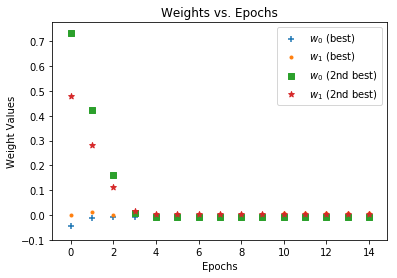

In [157]:
plt.scatter(range(15), best0_rms.W0_hist, label='$ w_0 $ (best)', marker="+")
plt.scatter(range(15), best0_rms.W1_hist, label='$ w_1 $ (best)', marker='.')
plt.scatter(range(15), best1_rms.W0_hist, label='$ w_0 $ (2nd best)', marker=",")
plt.scatter(range(15), best1_rms.W1_hist, label='$ w_1 $ (2nd best)', marker='*')
plt.xlabel("Epochs")
plt.ylabel("Weight Values")
plt.title("Weights vs. Epochs")
plt.legend()
plt.show()

 4. (2pts) Report the MSE at the end of 15 epochs for both combinations.

###### Vanilla SGD

In [163]:
print("For learning_rate={} and Lambda={}".format(best0.learning_rate, best0.Lambda))
pred = best0.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))

print("For learning_rate={} and Lambda={}".format(best1.learning_rate, best1.Lambda))
pred = best1.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))



For learning_rate=0.0001 and Lambda=100
MSE = 76.52608
For learning_rate=0.001 and Lambda=100
MSE = 76.88421


###### SGD with momentum

In [165]:
print("For learning_rate={} and Lambda={}".format(best0_mom.learning_rate, best0_mom.Lambda))
pred = best0_mom.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))

print("For learning_rate={} and Lambda={}".format(best1_mom.learning_rate, best1_mom.Lambda))
pred = best1_mom.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))

For learning_rate=0.0001 and Lambda=100
MSE = 76.55004
For learning_rate=0.001 and Lambda=100
MSE = 76.87586


###### RMSProp

In [168]:
print("For learning_rate={} and Lambda={}".format(best0_rms.learning_rate, best0_rms.Lambda))
pred = best0_rms.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))

print("For learning_rate={} and Lambda={}".format(best1_rms.learning_rate, best1_rms.Lambda))
pred = best1_rms.predict(X_train)
print("MSE = {:.5f}".format(mean_squared_error(y_train, pred)))



For learning_rate=1 and Lambda=100
MSE = 79.49918
For learning_rate=0.01 and Lambda=100
MSE = 76.81274


5. (3pts) Based on the experiments, which of the 3 techniques allowed for larger initial setting of the learning_rate? Why?


RMS prop allowed for the largest initial setting of the learning rate because it is the method which most dampens any oscillations during gradient descent.

In this particular case, the momentum was not enough to dampen the oscillations as the learning rate increased, but the moving average of rmsprop was enough and allowed the algorithm to converge at higher learning rates.

6. Now consider the following 2x2x1 network with one hidden layer. The input layer has two nodes, and the output layer has one node.

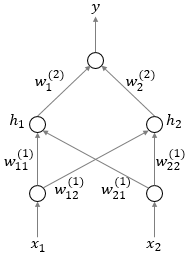

Both hidden layer units use a *sigmoid* activation function, and the output unit uses an identity activation (i.e. the output is just a weighted sum of the inputs).

(a) (2pts) Write the output $y$ as a function of the inputs $x_1$ and $x_2$.

(b) (2pts) Derive the update rule for the layer-one weight $w_{12}^{(1)}$.

# Notes on SGD with momentum
Momentum helps accelerate SGD in relevant direction and dampens the oscillations. It tries to maintain the direction in which the gradient vector was already pointing and adjusts the direction slowly with the new gradients. The steps can be listed below :
1. v[t] = mu * v[t-1] - (learning_rate)*(gradient)
2. w = w + v

Set mu = 0.90. Initialize v with zeros.


# Notes on RMSProp
RMSProp (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.  In particular, it uses a moving average of squared gradients as cache. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = (decay_rate)*(cache) + (1 - decay_rate)*(gradients^2) 
2. weights = weights - ((learning_rate)/sqrt(cache+1e-6))*gradients

Use decay_rate = 0.90. Initialize cache with zeros.

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

# Question 2 - Multi-layer perceptron Regressor (15 pts)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python;
http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html.


We will use the OpenCL gemm kernel performance prediction dataset for this problem; https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 30** and **test_size = 0.25**.

In [174]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline

data = pd.read_csv('sgemm_product.csv') 
data['target'] = 0.25*(data['Run1 (ms)'] + data['Run2 (ms)']+ data['Run3 (ms)'] + data['Run4 (ms)'])
y = data['target']
y = y.as_matrix()
X = data.drop(['target','Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=30)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(181200, 14) (181200,) (60400, 14) (60400,)


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y. 

1) (5pts) Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=30, learning_rate_init = 0.005
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model.

    (a) *hidden_layer_sizes = (2,)* 

In [201]:
X_train

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
84044,64,32,32,16,16,8,16,8,2,1,1,1,0,0
228272,128,128,32,16,8,8,16,2,1,8,0,0,0,0
815,16,16,32,8,8,8,8,8,2,1,1,1,1,1
89967,64,64,16,8,16,8,16,2,2,2,1,1,1,1
1887,16,32,16,8,8,8,32,8,2,1,1,1,1,1
216848,128,128,32,8,8,8,8,2,1,8,0,0,0,0
7076,16,64,16,16,8,8,8,8,1,4,0,1,0,0
163602,128,32,32,16,8,16,16,2,2,2,0,0,1,0
150484,128,32,16,8,8,16,8,2,4,2,0,1,0,0
66616,64,16,16,8,8,16,8,2,1,2,1,0,0,0


In [202]:
y_train

array([  51.135 ,  487.515 ,   87.0325, ...,  175.595 , 1129.1   ,
        514.2775])

In [222]:
k_fold = KFold(5)

mse = []

for train_index, test_index in k_fold.split(X_train, y_train):
    
    print("Train index: " + str(train_index))
    print("Test index: " + str(test_index))

    net = MLPRegressor(hidden_layer_sizes=(2,), 
                       activation = 'tanh', 
                       solver = 'sgd', 
                       learning_rate='constant', 
                       random_state=42,
                       batch_size=30, 
                       learning_rate_init = 0.005)
    
    net.fit(X_train[train_index], y_train[train_index])
    y_pred = net.predict(X_train[test_index])
    mse.append(mean_squared_error(y_train[test_index], y_pred))

min_mse = np.amin(mse)
print(min_mse)

Train index: [ 36240  36241  36242 ... 181197 181198 181199]
Test index: [    0     1     2 ... 36237 36238 36239]


KeyError: '[ 36240  36241  36242 ... 181197 181198 181199] not in index'

    (b) *hidden_layer_sizes = (10,)*

    (c) *hidden_layer_sizes = (30,)*

    (d) *hidden_layer_sizes = (50,)*

2) (5pts) Now, using the same parameters used in part 1), train MLPRegressor models on the entire training set and report the RMSE score for both the trainnig and testing sets (again, use StandardScaler). Which of the four models ((a)-(d)) performs the best? Briefly analyze and discuss the results, commenting on the number of hidden units.

3) (5pts) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves using below conditions (a, b, c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* valu;:

   (a) *hidden_layer_sizes = (1,)* 
   
   (b) *hidden_layer_sizes = (5,)*
   
   (c) *hidden_layer_sizes = (10,)*

## Answer

# Question 3 - [Kaggle Competition] Nomad2018 Predicting Transparent Conductors (25 pts)

In this problem, we are going to explore a Kaggle competition: [Transparent Conductors](https://www.kaggle.com/c/nomad2018-predict-transparent-conductors). Your goal is to obtain the best score you can in this competition.

The first step is to make a Kaggle account. Then find this competition and read the competition details and the description of the dataset. 

Your work should meet the following requirements:

1. Data Preprocessing. 
 * Conduct some data preprocessing. (Hint: see if there is any skewed features and consider applying suitable transformation techniques to make them more "normal").
 * Impute the missing values (if any).
 * Create new features using interactions
2. Predictive Models. 
 * You have to create three models: Lasso regression, Ridge regression, and multilayer perceptron.  For Lasso and Ridge regression, optimize the alphas using cross validation. For the MLP model, you can use one hidden layer. You may try other predictive models to get better scores (optional).
3. Get a score of 0.0800 or lower on the Private Leaderboard. Take a screenshot of your private leaderboard after submission as proof. You can also click My Submissions tab to see the history of your submissions. It will show both Public Leaderboard & Private Leaderboard score.

Briefly describe your work on each of these steps. Explain (very briefly) what approaches you tried, what worked and what did not work. Mention your team's kaggle name and include a screen shot of your public submission score. Finally, try your best to win this competition!

## Answer

# Question 4 - Bayes Decision Theory (10pts)

a. (2pts) Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.

b. (5pts) Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. The class label is 0 if the patient does not buy and 1 if he/she does. For each customer, you are given two features, x1 is the per hour salary and x2 is the age. Assume that the class conditional distribution $p(x_1,x_2|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 40 and 27 respectively and that of those who don't is 16 and 20. Assume that both classes of customers have the same covariance given by the Identity matrix. Further, your sales data suggests that only 1 in 5 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem.

c. (3pts) Write a script to sample 100 customers from each class (C = 0; 1) under the assumed distribution and the estimated parameters and plot their features. Plot the decision boundary you obtained in the part (b) on the same plot.

## Answer